In [47]:
!pip uninstall -y tensorflow seaborn keras tekeras-metal tensorflow-macos tf-keras
!pip install tensorflow-macos==2.14.0 seaborn

Found existing installation: seaborn 0.13.2
Uninstalling seaborn-0.13.2:
  Successfully uninstalled seaborn-0.13.2
Found existing installation: keras 2.14.0
Uninstalling keras-2.14.0:
  Successfully uninstalled keras-2.14.0
Found existing installation: tensorflow-macos 2.14.0
Uninstalling tensorflow-macos-2.14.0:
  Successfully uninstalled tensorflow-macos-2.14.0
  Using cached tensorflow_macos-2.14.0-cp310-cp310-macosx_12_0_arm64.whl.metadata (3.9 kB)
  Using cached seaborn-0.13.2-py3-none-any.whl.metadata (5.4 kB)
  Using cached keras-2.14.0-py3-none-any.whl.metadata (2.4 kB)
Using cached tensorflow_macos-2.14.0-cp310-cp310-macosx_12_0_arm64.whl (199.7 MB)
Using cached seaborn-0.13.2-py3-none-any.whl (294 kB)
Using cached keras-2.14.0-py3-none-any.whl (1.7 MB)


In [48]:
import numpy as np
import pennylane as qml
from pennylane import numpy as pnp
from pennylane.templates import RandomLayers
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
import cv2
import glob
import os
import random
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
from sklearn.model_selection import train_test_split
import os
import seaborn as sns

In [49]:
# Dataset parameters
TUMOR_IMAGE_PATH = '../data/brain_tumor_dataset/yes'  # Path to tumor images
HEALTHY_IMAGE_PATH = '../data/brain_tumor_dataset/no'  # Path to healthy images
img_size = (128, 128)  # Resize all images to this size
img_resize = (28, 28)  # Resize for quantum processing (to reduce computational load)

save_path = "./_static/quantum_brain_tumor/"

# Quantum parameters
n_qubits = 4  # Number of qubits in quantum circuit
n_layers = 2  # Number of random quantum layers
dev = qml.device("default.qubit", wires=n_qubits)  # Quantum device

# Training parameters
n_epochs = 20
batch_size = 4
validation_split = 0.2
learning_rate = 0.001

# Save path for quantum processed images
SAVE_PATH = "./_quantum_brain_data/"
if not os.path.exists(SAVE_PATH):
    os.makedirs(SAVE_PATH)

# Process quantum data or load from saved files
PREPROCESS = True
#np.random.seed(42)
#tf.random.set_seed(42)

In [50]:
def load_and_preprocess_images():
    """Load and preprocess brain tumor images"""
    tumor_images = []
    healthy_images = []
    
    # Load tumor images
    for file in glob.iglob(f"{TUMOR_IMAGE_PATH}/*.*"):
        try:
            img = cv2.imread(file)
            if img is None:
                print(f"Warning: Could not read image {file}")
                continue
            
            img = cv2.resize(img, img_size)
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            tumor_images.append(img)
        except Exception as e:
            print(f"Error processing {file}: {e}")
    
    # Load healthy images
    for file in glob.iglob(f"{HEALTHY_IMAGE_PATH}/*.*"):
        try:
            img = cv2.imread(file)
            if img is None:
                print(f"Warning: Could not read image {file}")
                continue
            
            img = cv2.resize(img, img_size)
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            healthy_images.append(img)
        except Exception as e:
            print(f"Error processing {file}: {e}")
    
    # Convert to numpy arrays
    tumor_images = np.array(tumor_images, dtype=np.float32) / 255.0
    healthy_images = np.array(healthy_images, dtype=np.float32) / 255.0
    
    # Create labels
    tumor_labels = np.ones(len(tumor_images))
    healthy_labels = np.zeros(len(healthy_images))
    
    # Combine data
    images = np.concatenate((tumor_images, healthy_images))
    labels = np.concatenate((tumor_labels, healthy_labels))
    
    print(f"Loaded {len(tumor_images)} tumor images and {len(healthy_images)} healthy images")
    return images, labels


In [51]:
# Load and preprocess the data
images, labels = load_and_preprocess_images()

# Split into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    images, labels, test_size=validation_split, random_state=42, stratify=labels
)

Loaded 155 tumor images and 98 healthy images


In [52]:
def plot_examples(tumor_imgs, healthy_imgs, num=5):
    """Plot random examples of tumor and healthy brain MRIs"""
    tumor_samples = tumor_imgs[np.random.choice(tumor_imgs.shape[0], num, replace=False)]
    healthy_samples = healthy_imgs[np.random.choice(healthy_imgs.shape[0], num, replace=False)]
    
    # Plot tumor images
    plt.figure(figsize=(15, 5))
    for i in range(num):
        plt.subplot(1, num, i+1)
        plt.title('Tumor')
        plt.imshow(tumor_samples[i])
        plt.axis('off')
    plt.tight_layout()
    plt.show()
    
    # Plot healthy images
    plt.figure(figsize=(15, 5))
    for i in range(num):
        plt.subplot(1, num, i+1)
        plt.title('Healthy')
        plt.imshow(healthy_samples[i])
        plt.axis('off')
    plt.tight_layout()
    plt.show()

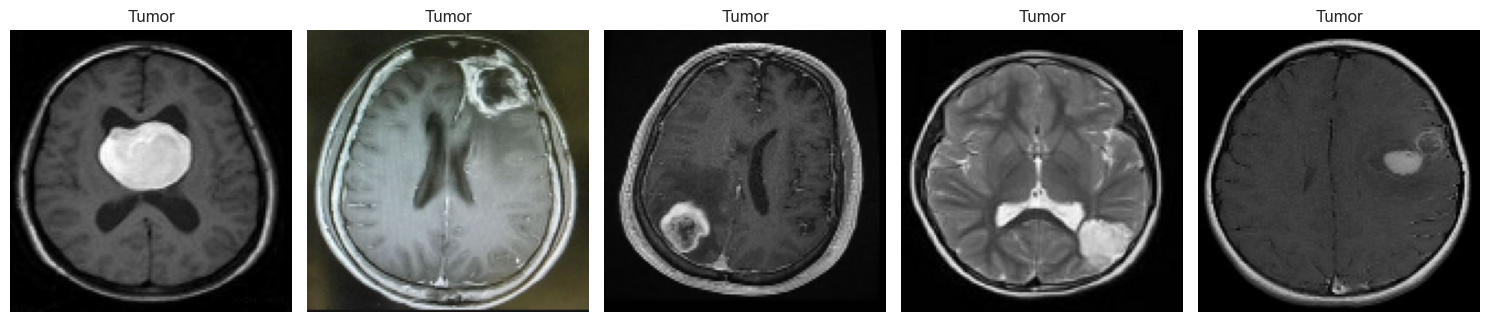

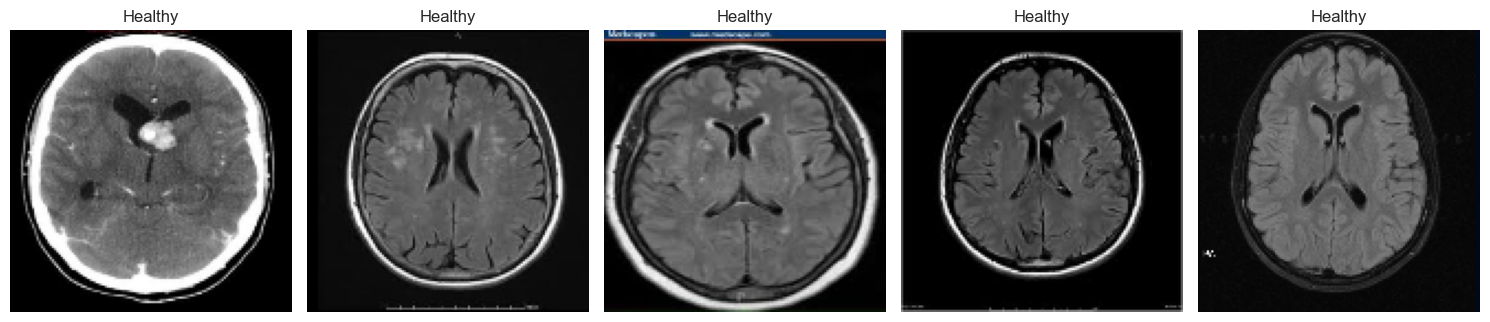

In [53]:
# Get tumor and healthy images separately
tumor_images = images[labels == 1]
healthy_images = images[labels == 0]

# Plot examples
plot_examples(tumor_images, healthy_images)

# ## Quantum Circuit Definition

# Random circuit parameters
rand_params = np.random.uniform(high=2 * np.pi, size=(n_layers, n_qubits))

In [54]:
@qml.qnode(dev)
def quantum_circuit(phi):
    """
    Quantum circuit for feature extraction
    
    Args:
        phi: 4 classical input values to encode
        
    Returns:
        Expectation values of Pauli-Z for each qubit
    """
    # Encode 4 classical input values
    for j in range(n_qubits):
        qml.RY(np.pi * phi[j], wires=j)
    
    # Apply random quantum layers
    RandomLayers(rand_params, wires=list(range(n_qubits)))
    
    # Measure qubits (expectation values)
    return [qml.expval(qml.PauliZ(j)) for j in range(n_qubits)]

In [55]:
def quantum_convolution(image):
    """
    Apply quantum convolution to an image
    
    Args:
        image: Input image (shape: height, width, channels)
        
    Returns:
        Quantum processed feature map
    """
    # First resize the image to reduce computation
    img = cv2.resize(image, img_resize)
    
    # Convert to grayscale for simplicity (average across channels)
    if img.shape[-1] == 3:
        img = np.mean(img, axis=-1)
    
    # Initialize output array
    out_size = img_resize[0] // 2
    out = np.zeros((out_size, out_size, n_qubits))
    
    # Loop over 2x2 patches of the image
    for j in range(0, img_resize[0], 2):
        for k in range(0, img_resize[1], 2):
            # Check if we can extract a 2x2 patch
            if j+1 < img_resize[0] and k+1 < img_resize[1]:
                # Process a 2x2 region with the quantum circuit
                q_results = quantum_circuit([
                    img[j, k],
                    img[j, k+1],
                    img[j+1, k],
                    img[j+1, k+1]
                ])
                
                # Assign results to different channels of the output
                for c in range(n_qubits):
                    out[j//2, k//2, c] = q_results[c]
    
    return out

In [56]:
def process_quantum_data(X_train, X_test):
    """Process all images with quantum convolution"""
    print("Processing training images with quantum convolution...")
    q_train_images = []
    for i, img in enumerate(X_train):
        print(f"Processing training image {i+1}/{len(X_train)}", end="\r")
        q_train_images.append(quantum_convolution(img))
    q_train_images = np.array(q_train_images)
    
    print("\nProcessing test images with quantum convolution...")
    q_test_images = []
    for i, img in enumerate(X_test):
        print(f"Processing test image {i+1}/{len(X_test)}", end="\r")
        q_test_images.append(quantum_convolution(img))
    q_test_images = np.array(q_test_images)
    
    return q_train_images, q_test_images

In [57]:
# Either process the data or load pre-processed data
if PREPROCESS:
    q_X_train, q_X_test = process_quantum_data(X_train, X_test)
    
    # Save the processed data
    np.save(SAVE_PATH + "q_X_train.npy", q_X_train)
    np.save(SAVE_PATH + "q_X_test.npy", q_X_test)
    np.save(SAVE_PATH + "y_train.npy", y_train)
    np.save(SAVE_PATH + "y_test.npy", y_test)
else:
    # Load pre-processed data if it exists
    try:
        q_X_train = np.load(SAVE_PATH + "q_X_train.npy")
        q_X_test = np.load(SAVE_PATH + "q_X_test.npy")
        y_train = np.load(SAVE_PATH + "y_train.npy")
        y_test = np.load(SAVE_PATH + "y_test.npy")
    except FileNotFoundError:
        print("Pre-processed data not found. Setting PREPROCESS=True.")
        q_X_train, q_X_test = process_quantum_data(X_train, X_test)
        np.save(SAVE_PATH + "q_X_train.npy", q_X_train)
        np.save(SAVE_PATH + "q_X_test.npy", q_X_test)
        np.save(SAVE_PATH + "y_train.npy", y_train)
        np.save(SAVE_PATH + "y_test.npy", y_test)

Processing training images with quantum convolution...
Processing training image 202/202
Processing test images with quantum convolution...
Processing test image 51/51

In [58]:
def visualize_quantum_features(original_images, quantum_images, labels, num_samples=3):
    """Visualize original images alongside their quantum processed versions"""
    plt.figure(figsize=(15, num_samples * 3))
    
    for i in range(num_samples):
        # Choose random samples
        idx = np.random.randint(0, len(original_images))
        original = original_images[idx]
        quantum = quantum_images[idx]
        label = "Tumor" if labels[idx] == 1 else "Healthy"
        
        # Plot original image
        plt.subplot(num_samples, 5, i*5 + 1)
        plt.title(f"Original ({label})")
        plt.imshow(original)
        plt.axis('off')
        
        # Plot quantum channels
        for c in range(n_qubits):
            plt.subplot(num_samples, 5, i*5 + c + 2)
            plt.title(f"Q-Channel {c}")
            plt.imshow(quantum[:, :, c], cmap='viridis')
            plt.axis('off')
    
    plt.tight_layout()
    plt.show()

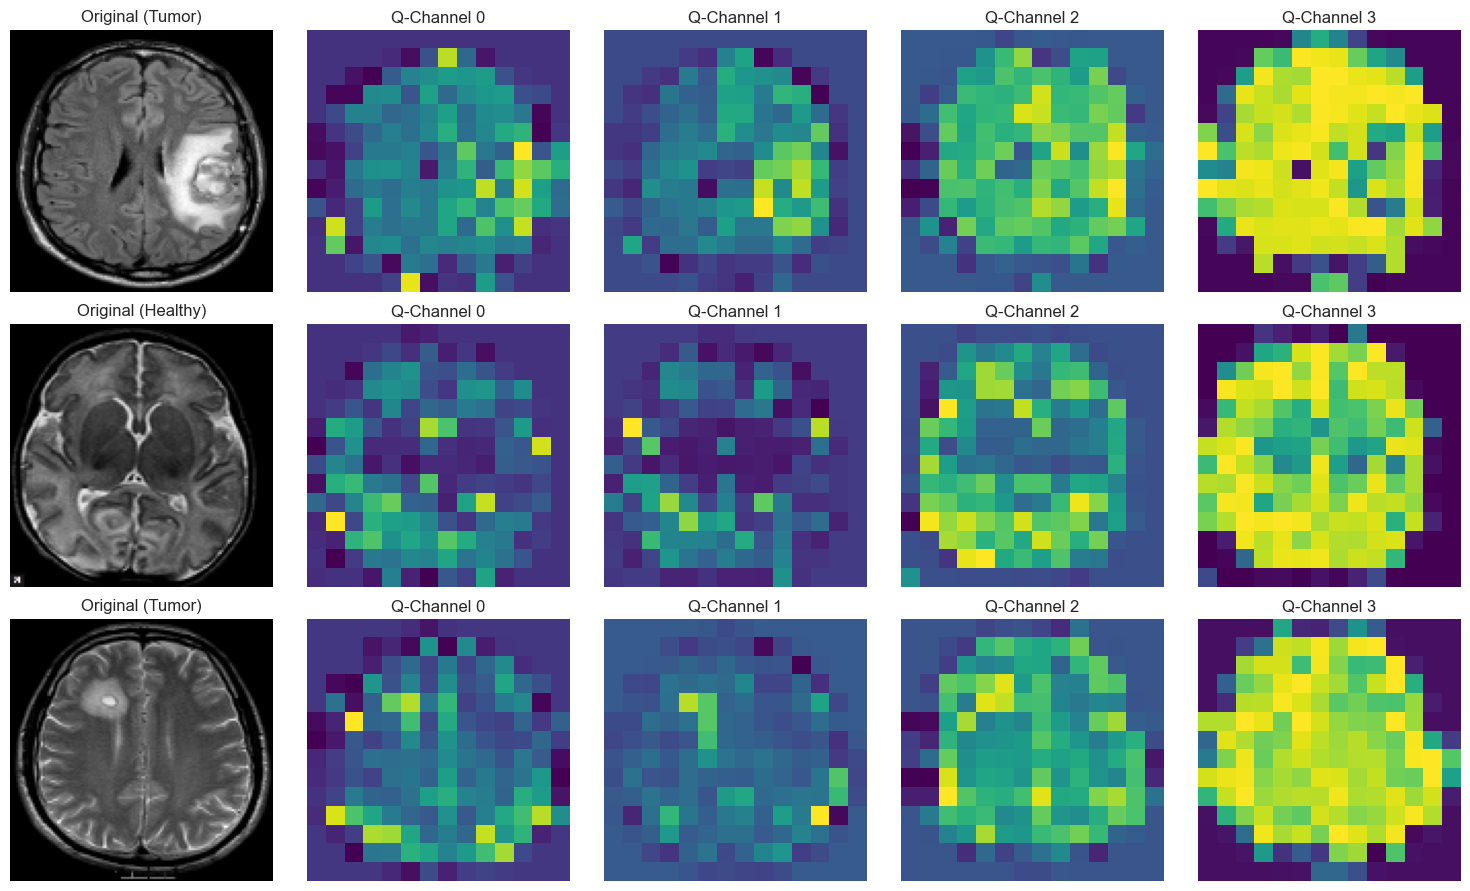

In [59]:
# Visualize samples
visualize_quantum_features(X_train, q_X_train, y_train)

In [60]:
# ## Classical Post-Processing Model

def create_hybrid_model(input_shape):
    """Create a hybrid quantum-classical model"""
    model = keras.Sequential([
        keras.layers.Input(shape=input_shape),
        keras.layers.Flatten(),
        keras.layers.Dense(64, activation='relu'),
        keras.layers.Dropout(0.3),
        keras.layers.Dense(32, activation='relu'),
        keras.layers.Dropout(0.2),
        keras.layers.Dense(1, activation='sigmoid')
    ])
    
    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=learning_rate),
        loss='binary_crossentropy',
        metrics=['accuracy']
    )
    
    return model

In [61]:
# ## Training the Model

# Create both quantum and classical models for comparison
q_model = create_hybrid_model(q_X_train.shape[1:])
c_model = create_hybrid_model(c_X_train.shape[1:])  # <- Use classical data shape instead

# Create transformed classical features for comparison (resize to match quantum)
c_X_train = np.array([cv2.resize(img, (q_X_train.shape[1], q_X_train.shape[2])) for img in X_train])
c_X_train = np.mean(c_X_train, axis=-1)[..., np.newaxis]  # Add channel dimension
c_X_test = np.array([cv2.resize(img, (q_X_test.shape[1], q_X_test.shape[2])) for img in X_test])
c_X_test = np.mean(c_X_test, axis=-1)[..., np.newaxis]  # Add channel dimension

# Reshape if needed for the model
if len(q_X_train.shape) == 4:
    q_X_train_reshaped = q_X_train
    q_X_test_reshaped = q_X_test
else:
    q_X_train_reshaped = q_X_train.reshape(q_X_train.shape[0], q_X_train.shape[1], q_X_train.shape[2], 1)
    q_X_test_reshaped = q_X_test.reshape(q_X_test.shape[0], q_X_test.shape[1], q_X_test.shape[2], 1)

# Train the quantum model
print("\nTraining quantum model...")
q_history = q_model.fit(
    q_X_train, y_train,
    validation_data=(q_X_test, y_test),
    epochs=n_epochs,
    batch_size=batch_size,
    verbose=1
)

# Train the classical model for comparison
print("\nTraining classical model...")
c_history = c_model.fit(
    c_X_train, y_train,
    validation_data=(c_X_test, y_test),
    epochs=n_epochs,
    batch_size=batch_size,
    verbose=1
)


Training quantum model...
Epoch 1/20
11/51 [=====>........................] - ETA: 0s - loss: 0.9419 - accuracy: 0.5682 

2025-03-24 20:28:29.566805: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node Adam/AssignAddVariableOp.


51/51 [==============================] - 1s 10ms/step - loss: 0.8871 - accuracy: 0.6683 - val_loss: 1.1375 - val_accuracy: 0.4902
Epoch 2/20
51/51 [==============================] - 0s 6ms/step - loss: 0.6246 - accuracy: 0.6733 - val_loss: 0.5788 - val_accuracy: 0.7255
Epoch 3/20
51/51 [==============================] - 0s 6ms/step - loss: 0.5642 - accuracy: 0.7277 - val_loss: 0.5907 - val_accuracy: 0.7451
Epoch 4/20
51/51 [==============================] - 0s 6ms/step - loss: 0.5922 - accuracy: 0.7327 - val_loss: 0.9796 - val_accuracy: 0.4510
Epoch 5/20
51/51 [==============================] - 0s 6ms/step - loss: 0.5676 - accuracy: 0.7327 - val_loss: 0.7360 - val_accuracy: 0.5490
Epoch 6/20
51/51 [==============================] - 0s 6ms/step - loss: 0.4892 - accuracy: 0.7822 - val_loss: 0.6918 - val_accuracy: 0.6078
Epoch 7/20
51/51 [==============================] - 0s 6ms/step - loss: 0.4875 - accuracy: 0.7921 - val_loss: 0.6000 - val_accuracy: 0.7451
Epoch 8/20
51/51 [============

In [62]:
# Evaluate the models
q_test_loss, q_test_acc = q_model.evaluate(q_X_test, y_test) 
c_test_loss, c_test_acc = c_model.evaluate(c_X_test, y_test) 

print(f"Quantum model - Test accuracy: {q_test_acc:.4f}, Test loss: {q_test_loss:.4f}")
print(f"Classical model - Test accuracy: {c_test_acc:.4f}, Test loss: {c_test_loss:.4f}")

2/2 [==============================] - 0s 28ms/step - loss: 0.6816 - accuracy: 0.6863
Quantum model - Test accuracy: 0.6667, Test loss: 0.9572
Classical model - Test accuracy: 0.6863, Test loss: 0.6816


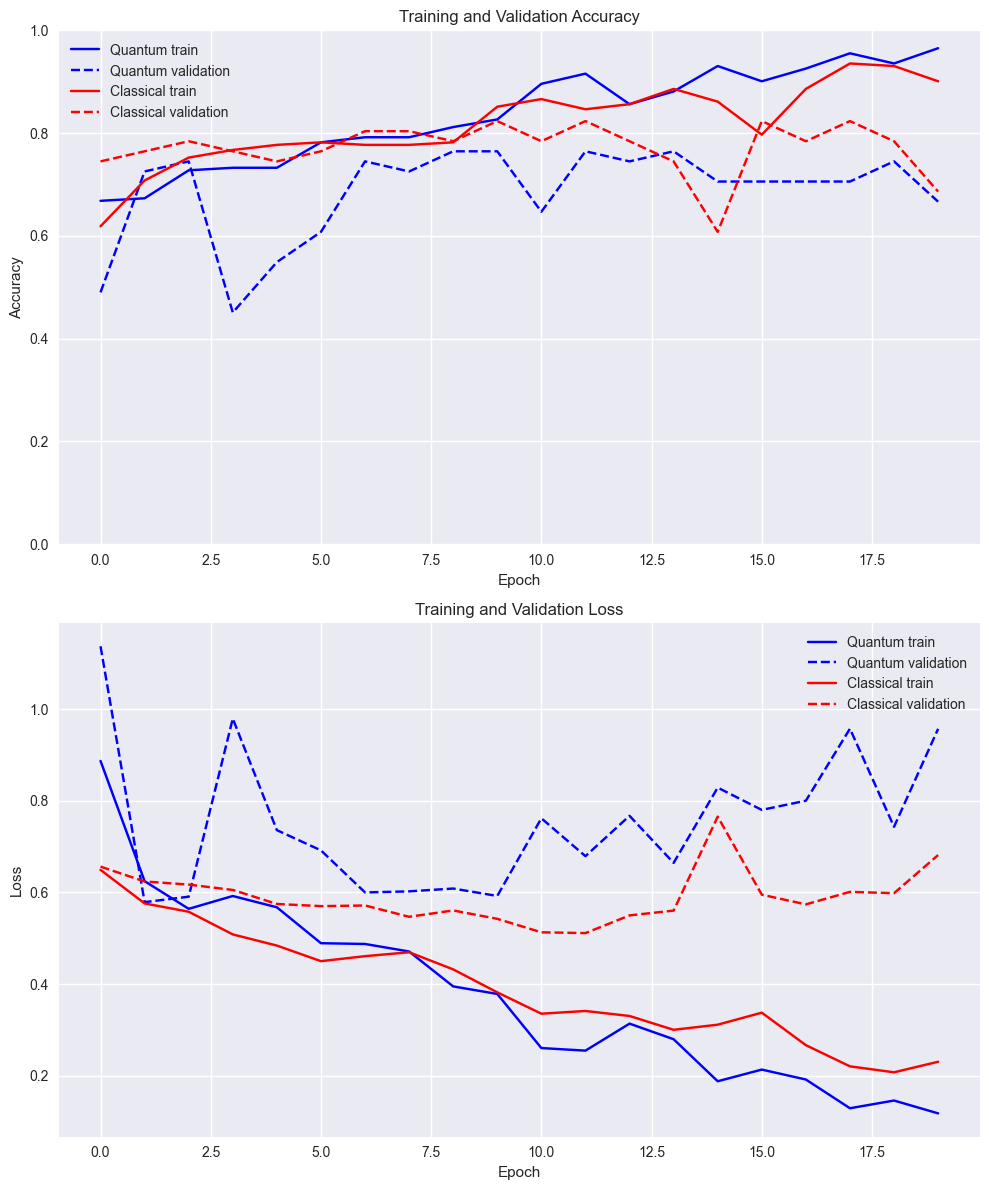

In [63]:
# Plot training history
plt.style.use("seaborn-v0_8")
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 12))

# Plot accuracy
ax1.plot(q_history.history["accuracy"], "-b", label="Quantum train")
ax1.plot(q_history.history["val_accuracy"], "--b", label="Quantum validation")
ax1.plot(c_history.history["accuracy"], "-r", label="Classical train")
ax1.plot(c_history.history["val_accuracy"], "--r", label="Classical validation")
ax1.set_ylabel("Accuracy")
ax1.set_ylim([0, 1])
ax1.set_xlabel("Epoch")
ax1.legend()
ax1.grid(True)
ax1.set_title("Training and Validation Accuracy")

# Plot loss
ax2.plot(q_history.history["loss"], "-b", label="Quantum train")
ax2.plot(q_history.history["val_loss"], "--b", label="Quantum validation")
ax2.plot(c_history.history["loss"], "-r", label="Classical train")
ax2.plot(c_history.history["val_loss"], "--r", label="Classical validation")
ax2.set_ylabel("Loss")
ax2.set_xlabel("Epoch")
ax2.legend()
ax2.grid(True)
ax2.set_title("Training and Validation Loss")

plt.tight_layout()
plt.show()

In [64]:
# Generate predictions
q_predictions = q_model.predict(q_X_test) 
q_pred_classes = (q_predictions > 0.5).astype(int).reshape(-1)

c_predictions = c_model.predict(c_X_test) 
c_pred_classes = (c_predictions > 0.5).astype(int).reshape(-1)

2/2 [==============================] - 0s 4ms/step


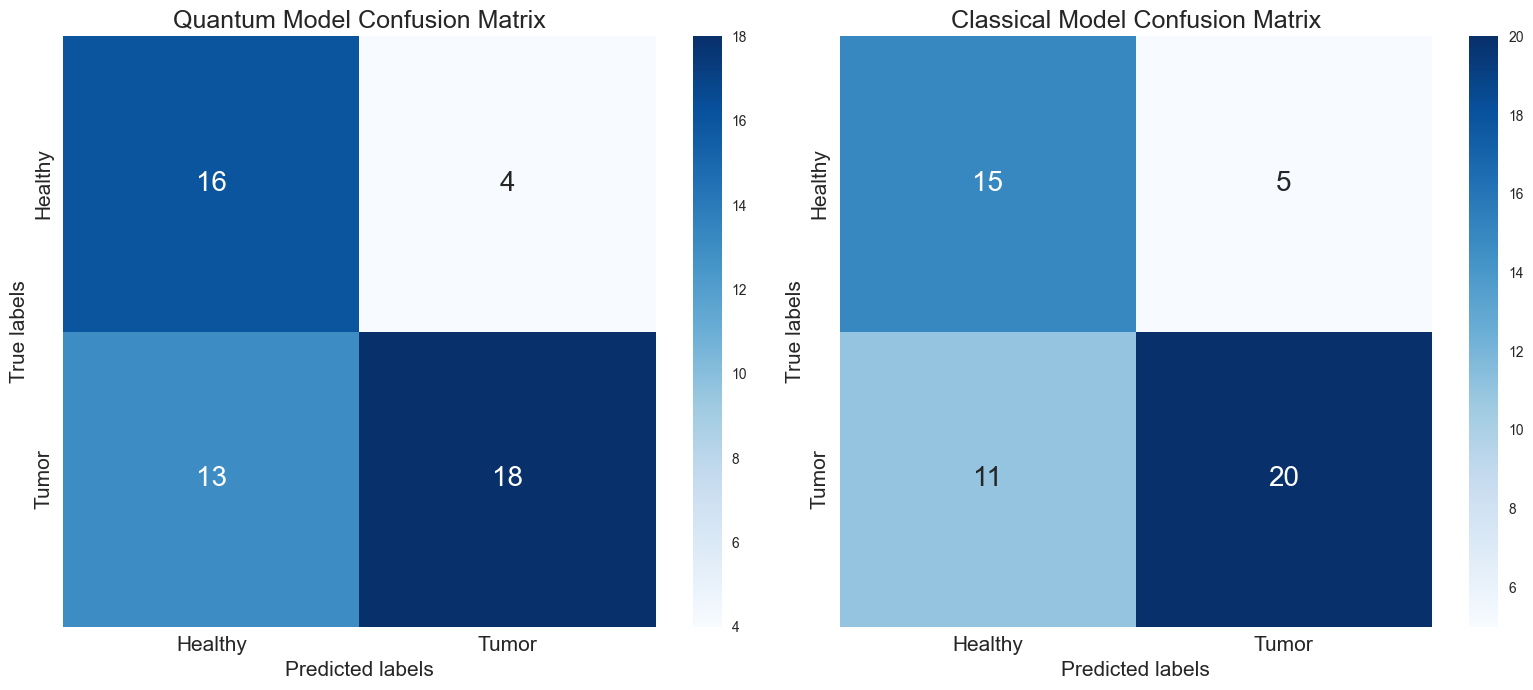

Quantum Model Classification Report:
              precision    recall  f1-score   support

     Healthy       0.55      0.80      0.65        20
       Tumor       0.82      0.58      0.68        31

    accuracy                           0.67        51
   macro avg       0.68      0.69      0.67        51
weighted avg       0.71      0.67      0.67        51


Classical Model Classification Report:
              precision    recall  f1-score   support

     Healthy       0.58      0.75      0.65        20
       Tumor       0.80      0.65      0.71        31

    accuracy                           0.69        51
   macro avg       0.69      0.70      0.68        51
weighted avg       0.71      0.69      0.69        51



In [65]:
# Create confusion matrices
def plot_confusion_matrices():
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 7))
    
    # Quantum model confusion matrix
    cm1 = confusion_matrix(y_test, q_pred_classes)
    sns.heatmap(cm1, annot=True, fmt='g', ax=ax1, cmap='Blues',
                annot_kws={"size": 20})
    ax1.set_xlabel('Predicted labels', fontsize=15)
    ax1.set_ylabel('True labels', fontsize=15)
    ax1.set_title('Quantum Model Confusion Matrix', fontsize=18)
    ax1.xaxis.set_ticklabels(['Healthy', 'Tumor'], fontsize=15)
    ax1.yaxis.set_ticklabels(['Healthy', 'Tumor'], fontsize=15)
    
    # Classical model confusion matrix
    cm2 = confusion_matrix(y_test, c_pred_classes)
    sns.heatmap(cm2, annot=True, fmt='g', ax=ax2, cmap='Blues',
                annot_kws={"size": 20})
    ax2.set_xlabel('Predicted labels', fontsize=15)
    ax2.set_ylabel('True labels', fontsize=15)
    ax2.set_title('Classical Model Confusion Matrix', fontsize=18)
    ax2.xaxis.set_ticklabels(['Healthy', 'Tumor'], fontsize=15)
    ax2.yaxis.set_ticklabels(['Healthy', 'Tumor'], fontsize=15)
    
    plt.tight_layout()
    plt.show()
    
    # Print classification reports
    print("Quantum Model Classification Report:")
    print(classification_report(y_test, q_pred_classes, 
                               target_names=['Healthy', 'Tumor']))
    
    print("\nClassical Model Classification Report:")
    print(classification_report(y_test, c_pred_classes, 
                               target_names=['Healthy', 'Tumor']))

plot_confusion_matrices()

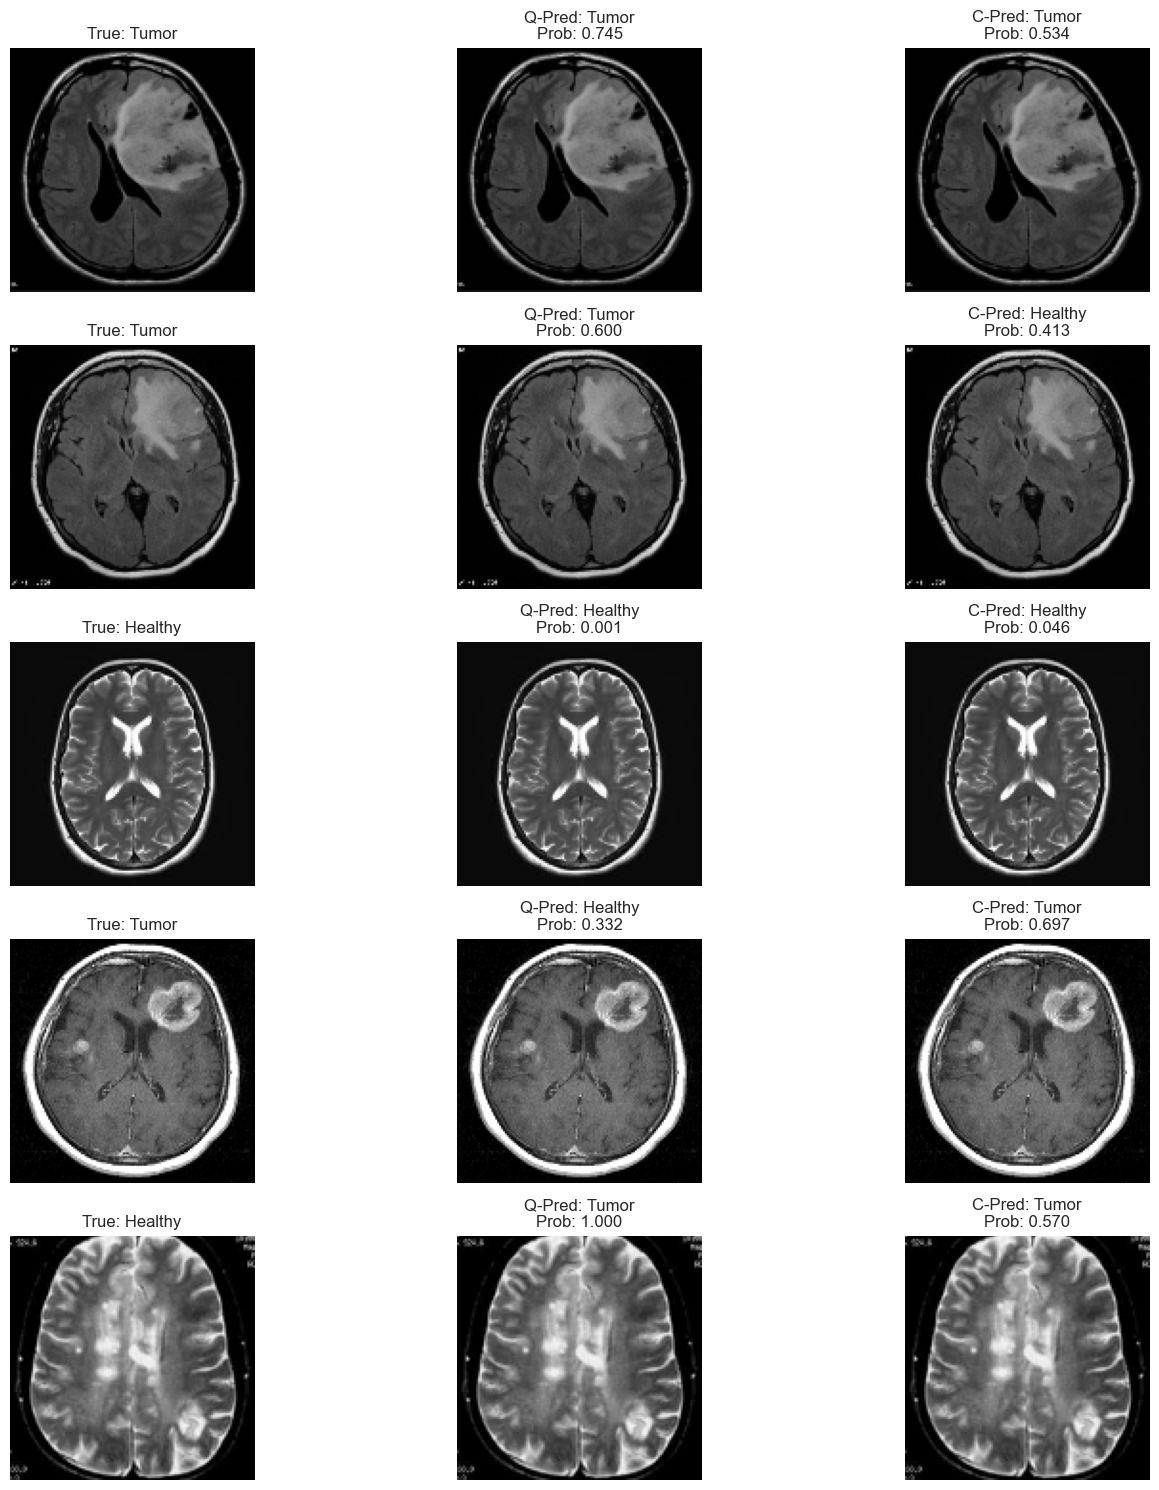

In [66]:
# Visualize predictions
def visualize_predictions(n_samples=5):
    # Get random samples from test set
    indices = np.random.choice(len(X_test), n_samples, replace=False)
    
    plt.figure(figsize=(15, n_samples * 3))
    
    for i, idx in enumerate(indices):
        original_img = X_test[idx]
        true_label = y_test[idx]
        q_pred = q_pred_classes[idx]
        c_pred = c_pred_classes[idx]
        q_prob = q_predictions[idx][0]
        c_prob = c_predictions[idx][0]
        
        plt.subplot(n_samples, 3, i*3 + 1)
        plt.imshow(original_img)
        plt.title(f"True: {'Tumor' if true_label == 1 else 'Healthy'}")
        plt.axis('off')
        
        plt.subplot(n_samples, 3, i*3 + 2)
        plt.imshow(original_img)
        plt.title(f"Q-Pred: {'Tumor' if q_pred == 1 else 'Healthy'}\nProb: {q_prob:.3f}")
        color = 'green' if q_pred == true_label else 'red'
        plt.gca().spines['bottom'].set_color(color)
        plt.gca().spines['top'].set_color(color)
        plt.gca().spines['left'].set_color(color)
        plt.gca().spines['right'].set_color(color)
        plt.gca().spines['bottom'].set_linewidth(5)
        plt.gca().spines['top'].set_linewidth(5)
        plt.gca().spines['left'].set_linewidth(5)
        plt.gca().spines['right'].set_linewidth(5)
        plt.axis('off')
        
        plt.subplot(n_samples, 3, i*3 + 3)
        plt.imshow(original_img)
        plt.title(f"C-Pred: {'Tumor' if c_pred == 1 else 'Healthy'}\nProb: {c_prob:.3f}")
        color = 'green' if c_pred == true_label else 'red'
        plt.gca().spines['bottom'].set_color(color)
        plt.gca().spines['top'].set_color(color)
        plt.gca().spines['left'].set_color(color)
        plt.gca().spines['right'].set_color(color)
        plt.gca().spines['bottom'].set_linewidth(5)
        plt.gca().spines['top'].set_linewidth(5)
        plt.gca().spines['left'].set_linewidth(5)
        plt.gca().spines['right'].set_linewidth(5)
        plt.axis('off')
    
    plt.tight_layout()
    plt.show()

visualize_predictions(5)


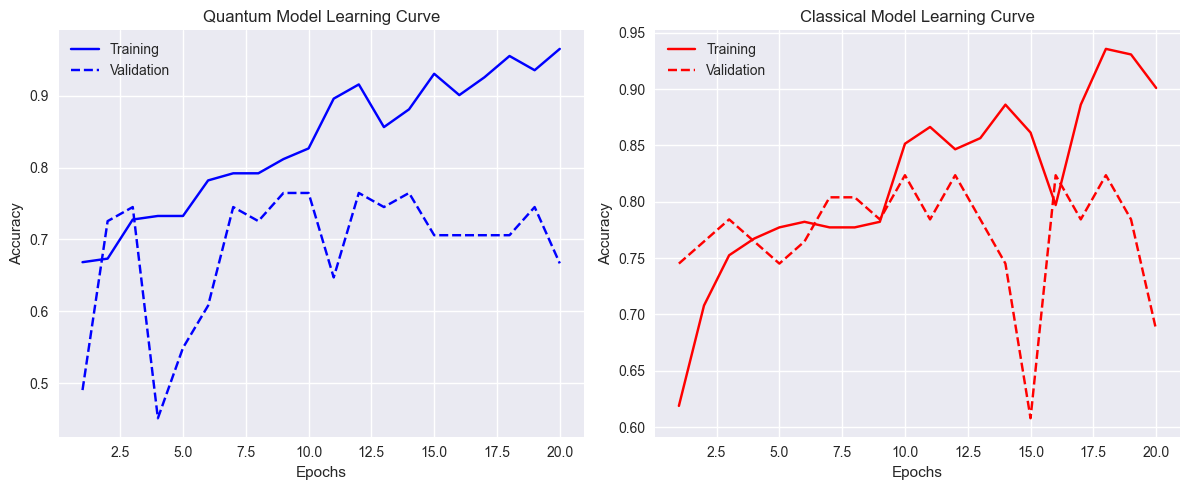

In [67]:
# Additional Analysis: Learning Curve
def plot_learning_curve():
    """Plot learning curves to analyze model performance over epochs"""
    plt.figure(figsize=(12, 5))
    
    plt.subplot(1, 2, 1)
    plt.plot(range(1, n_epochs+1), q_history.history['accuracy'], 'b-', label='Training')
    plt.plot(range(1, n_epochs+1), q_history.history['val_accuracy'], 'b--', label='Validation')
    plt.title('Quantum Model Learning Curve')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True)
    
    plt.subplot(1, 2, 2)
    plt.plot(range(1, n_epochs+1), c_history.history['accuracy'], 'r-', label='Training')
    plt.plot(range(1, n_epochs+1), c_history.history['val_accuracy'], 'r--', label='Validation')
    plt.title('Classical Model Learning Curve')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True)
    
    plt.tight_layout()
    plt.show()

plot_learning_curve()

Tumor sample features:


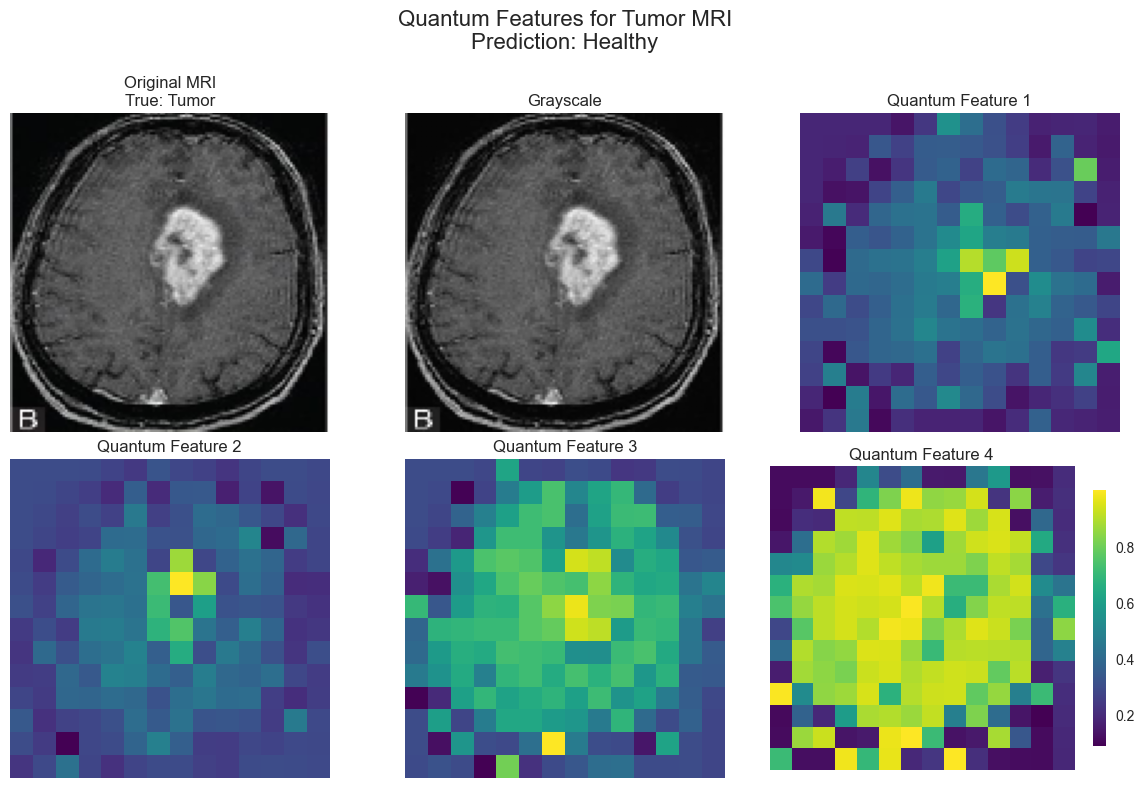

Healthy sample features:


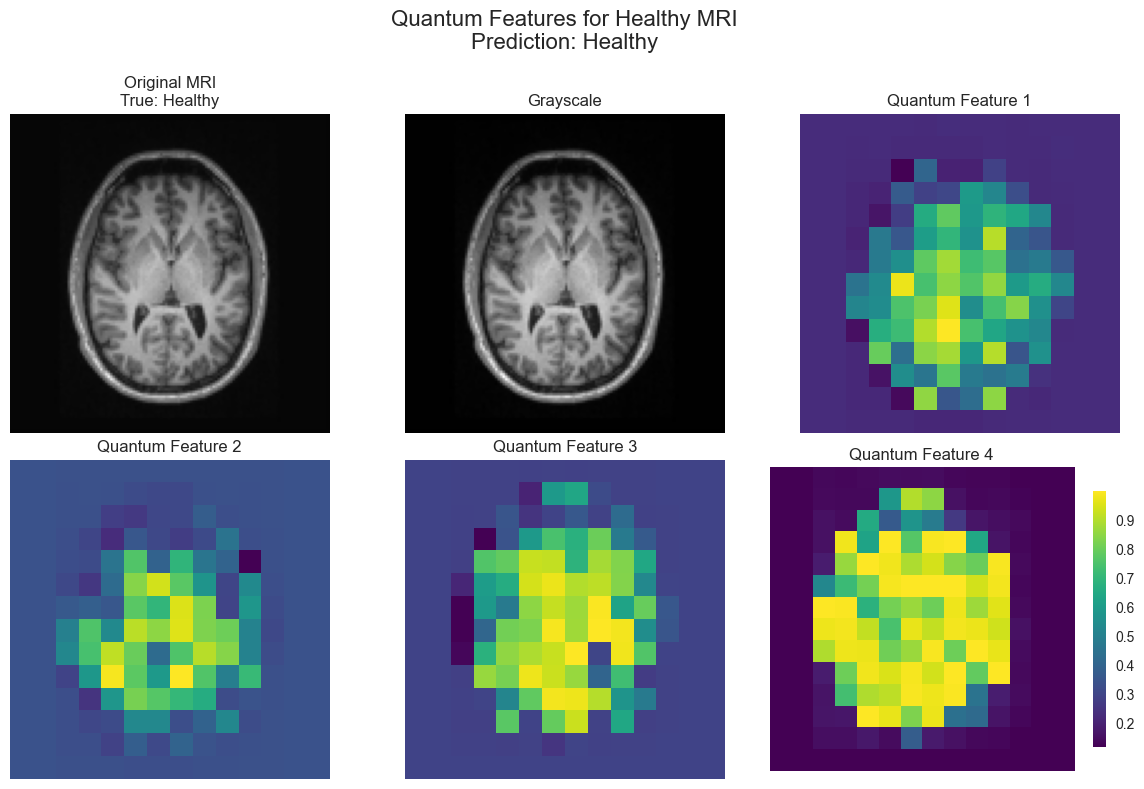

In [68]:
# Visualize feature maps
def visualize_feature_maps(sample_idx=0):
    """Visualize and compare original input with quantum feature maps"""
    
    original_img = X_test[sample_idx]
    quantum_features = q_X_test[sample_idx]
    true_label = y_test[sample_idx]
    q_pred = q_pred_classes[sample_idx]
    
    # Plot
    fig = plt.figure(figsize=(12, 8))
    
    # Original image
    ax1 = fig.add_subplot(2, 3, 1)
    ax1.imshow(original_img)
    ax1.set_title(f"Original MRI\nTrue: {'Tumor' if true_label == 1 else 'Healthy'}")
    ax1.axis('off')
    
    # Grayscale version (averaged channels)
    ax2 = fig.add_subplot(2, 3, 2)
    gray_img = np.mean(original_img, axis=2)
    ax2.imshow(gray_img, cmap='gray')
    ax2.set_title("Grayscale")
    ax2.axis('off')
    
    # Quantum feature maps
    for i in range(4):
        ax = fig.add_subplot(2, 3, i+3)
        im = ax.imshow(quantum_features[:, :, i], cmap='viridis')
        ax.set_title(f"Quantum Feature {i+1}")
        ax.axis('off')
    
    plt.colorbar(im, ax=fig.axes[5], shrink=0.8)
    plt.tight_layout()
    plt.suptitle(f"Quantum Features for {'Tumor' if true_label == 1 else 'Healthy'} MRI\n"
                 f"Prediction: {'Tumor' if q_pred == 1 else 'Healthy'}", fontsize=16)
    plt.subplots_adjust(top=0.85)
    plt.show()

# Show features for one tumor and one healthy sample
tumor_idx = np.where(y_test == 1)[0][0]
healthy_idx = np.where(y_test == 0)[0][0]

print("Tumor sample features:")
visualize_feature_maps(tumor_idx)

print("Healthy sample features:")
visualize_feature_maps(healthy_idx)